# Project : Registration of anatomical and functional pelvis images

Charline Curaut 3810013

### Useful libraires and functions

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.optimize import fsolve
import math
#import imutils

In [3]:
def load_nii(difficulty, f_name):
    
    path = 'EXAMPLE-b0-T2/' + difficulty + '/' + f_name
    img = nib.load(path)
    #print(f'image affine before canonical \n{img.affine}')
    print(f'voxel orientation : {nib.aff2axcodes(img.affine)}')
    canonical_img = nib.as_closest_canonical(img)
    #print(f'image affine after canonical \n{canonical_img.affine}')
    print(f'voxel orientation : {nib.aff2axcodes(canonical_img.affine)}')
    
    return canonical_img.get_fdata(), canonical_img.affine

## Manipulation of data to get familiarized

Let's first put the images along the same voxel orientation.

In [4]:
minor_b0, affine_b0 = load_nii('minor','1-2-14_off_210111_b0DWI.nii')
#print(f'image affine after canonical \n{img.affine}')
print(minor_b0.shape)

minor_T2, affine_T2 = load_nii('minor','1-2-14_off_210111_coroT2Cube.nii')
print(minor_T2.shape)

minor_T2_mask, affine_T2_mask = load_nii('minor','1-2-14_off_210111_T2Mask.nii')
print(minor_T2_mask.shape)

minor_Segmentation_T2, affine_T2_seg = load_nii('minor','1-2-14_off_210111_Segmentation.nii')
print(minor_Segmentation_T2.shape)

voxel orientation : ('L', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(256, 256, 75)
voxel orientation : ('R', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(400, 179, 400)
voxel orientation : ('R', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(400, 179, 400)
voxel orientation : ('R', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(400, 179, 400)


In [5]:
print(np.unique(minor_b0))
print(np.unique(minor_T2))
print(np.unique(minor_T2_mask))
print(np.unique(minor_Segmentation_T2))

[ 1075.  1076.  1077. ... 32457. 32560. 32767.]
[0.00000000e+00 4.57295858e-35 1.13290205e-30 ... 9.91978027e+03
 9.93124707e+03 9.94759961e+03]
[0. 1.]
[ 0.  5.  9. 10. 14. 15. 18. 21. 24. 27. 33. 36. 42. 43. 44. 45. 49. 54.
 55. 61.]


### Visualization of a slice for each data (b0, T2 and T2_mask) (they don't necessarily correspond between one another) :

#### Axial slices

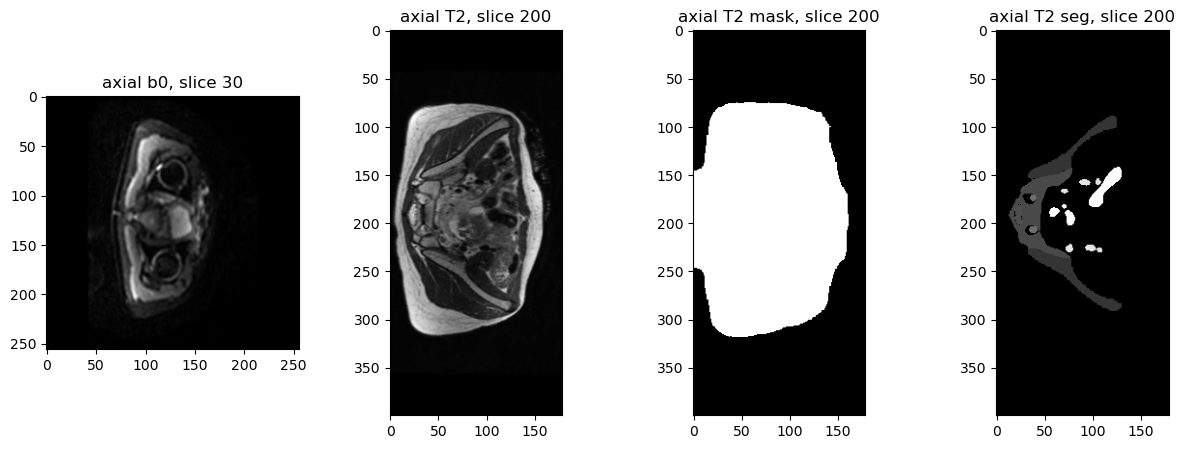

In [6]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
axial_b0 = minor_b0[:,:,30]
plt.imshow(axial_b0, cmap="gray")
plt.title("axial b0, slice 30")

plt.subplot(1,4,2)
axial_T2 = minor_T2[:,:,200]
plt.imshow(axial_T2, cmap="gray")
plt.title("axial T2, slice 200")

plt.subplot(1,4,3)
axial_T2_mask = minor_T2_mask[:,:,200]
plt.imshow(axial_T2_mask, cmap="gray")
plt.title("axial T2 mask, slice 200")

plt.subplot(1,4,4)
axial_seg_T2 = minor_Segmentation_T2[:,:,200]
plt.imshow(axial_seg_T2, cmap="gray")
plt.title("axial T2 seg, slice 200")

plt.show()

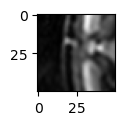

In [8]:
fig = plt.figure(figsize=(1,5))
plt.imshow(axial_b0[100:150,50:100], cmap='gray')
plt.show()

The coordinates are in RAS+ so we have (x,y,z) with x that increases to the Right, y that increases to the Anterior part, and z that increases to Superior part. Here, the images are displayed with the x axis being the vertical axis, and the y axis being the horizontal axis. 

#### Coronal slices

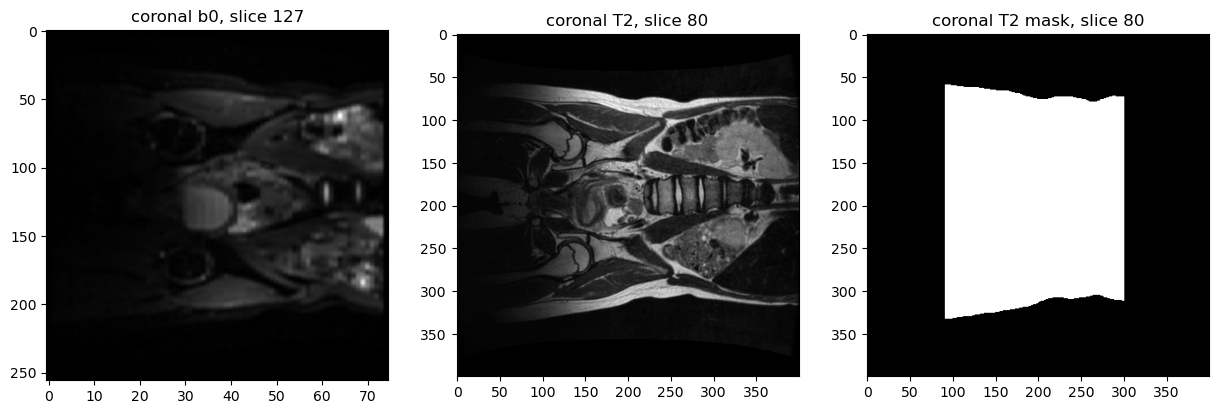

In [58]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,127,:]
plt.imshow(coronal_b0, cmap="gray")
plt.gca().set_aspect(aspect=0.3)
plt.title("coronal b0, slice 127")

plt.subplot(1,3,2)
coronal_T2 = minor_T2[:,80,:]
plt.imshow(coronal_T2, cmap="gray")
plt.title("coronal T2, slice 80")

plt.subplot(1,3,3)
coronal_T2_mask = minor_T2_mask[:,80,:]
plt.imshow(coronal_T2_mask, cmap="gray")
plt.title("coronal T2 mask, slice 80")

plt.show()

#### Sagittal slices

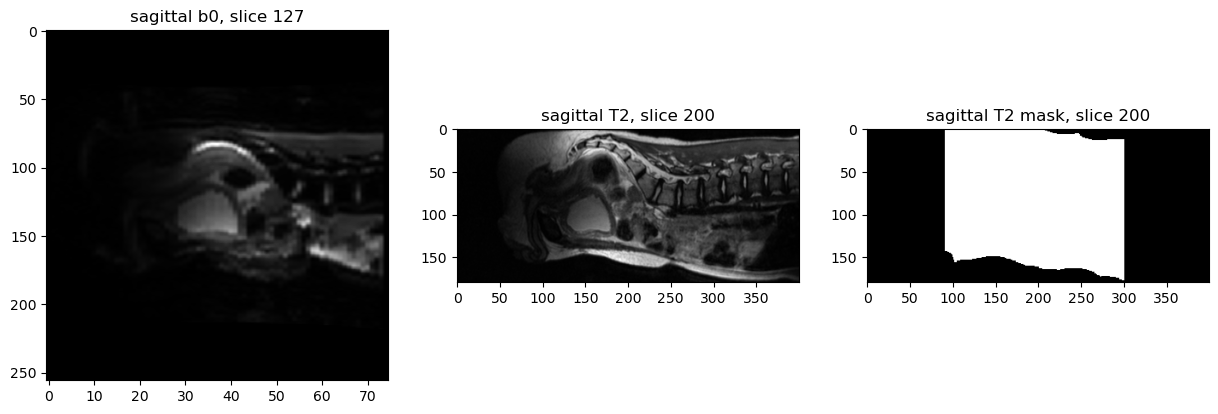

In [59]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sagittal_b0 = minor_b0[127,:,:]
plt.imshow(sagittal_b0, cmap="gray")
plt.gca().set_aspect(aspect=0.3)
plt.title("sagittal b0, slice 127")

plt.subplot(1,3,2)
sagittal_T2 = minor_T2[200,:,:]
plt.imshow(sagittal_T2, cmap="gray")
plt.title("sagittal T2, slice 200")

plt.subplot(1,3,3)
sagittal_T2_mask = minor_T2_mask[200,:,:]
plt.imshow(sagittal_T2_mask, cmap="gray")
plt.title("sagittal T2 mask, slice 200")

plt.show()

#### Cuting axial slice T2 according to given mask

In [15]:
# on manipule chaque coupe coronale pour éliminer des coupes axiales.

def cut_T2_coro(T2, T2_mask, coordinates=False) :
    """ 
    Search for each coronal slice the first and last y-coordinate pixel (which correspond to z-corrdinate voxel)
    Return a cut version of T2 (with less axial slices)
    """

    z_max = 0
    z_min = T2.shape[2]

    for i in range(T2.shape[1]) :
        slice_coro = T2[:,i,:]
        slice_coro_mask = T2_mask[:,i,:]

        for y in range(slice_coro.shape[1]) :
            if 1.0 in slice_coro_mask[:,y]:
                if y < z_min :
                    z_min = y
                break

        for y in range(slice_coro.shape[1]-1,-1,-1) :
            if 1.0 in slice_coro_mask[:,y] :
                if y > z_max :
                    z_max = y
                break
     
    if coordinates :
        return z_min, z_max

    return T2[:,:,z_min:z_max], T2_mask[:,:,z_min:z_max]

In [120]:
minor_T2_cut, minor_T2_mask_cut = cut_T2_coro(minor_T2, minor_T2_mask)
print(minor_T2_cut.shape)

(400, 179, 209)


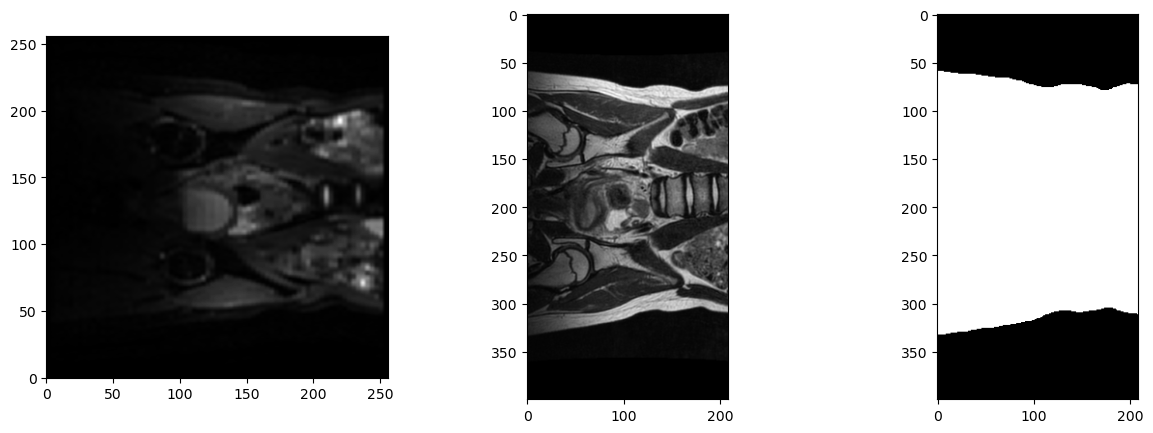

In [163]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,127,:]
plt.imshow(coronal_b0, cmap="gray", extent=(0,256,0,256))

plt.subplot(1,3,2)
coronal_T2_cut = minor_T2_cut[:,80,:]
plt.imshow(coronal_T2_cut, cmap="gray")

plt.subplot(1,3,3)
coronal_T2_mask_cut = minor_T2_mask_cut[:,80,:]
plt.imshow(coronal_T2_mask_cut, cmap="gray")

plt.show()

Right now there are 75 axial b0 slices of thickness 3.5 mm, and 209 axial T2 slices of thickness 0.8 mm. We still have to resample T2. Which mean that the size of the coronal region covered by b0 is $75 * 3.5 = 262.5 mm$ and the one covered by T2 is $ 209 * 0.8 = 167.2 mm$. The surface of T2 is now lesser than that of b0. 

Ce n'est peut être pas la bonne méthode (ajuster la taille des images jusqu'à avoir une surface environ équivalente) pour faire le ré-échantillonage.
--> à la place : utiliser la matrice affine qui fait passer les coordonnées des voxels dans l'espace Scanner RAS+ --> ça met les deux images en relation et on peut comparer les slices axiales entre elles.

### Resampling of T2

In [10]:
x = np.array(
    [[[0,0,4,4],[0,0,4,4],[1,1,5,5],[1,1,5,5]],
     [[0,0,4,4],[0,0,4,4],[1,1,5,5],[1,1,5,5]],
     [[2,2,6,6],[2,2,6,6],[3,3,7,7],[3,3,7,7]],
     [[2,2,6,6],[2,2,6,6],[3,3,7,7],[3,3,7,7]]] )
print(x[:,:,0])

[[0 0 1 1]
 [0 0 1 1]
 [2 2 3 3]
 [2 2 3 3]]


In [11]:
resample_x0_5 = scipy.ndimage.zoom(x, (0.5, 0.5, 0.5), order=1)
#print(resample_x0_5)
print(resample_x0_5[:,:,0])

[[0 1]
 [2 3]]


In [12]:
scale = 0.8 / 3.5
print(f'scale = {scale}\n')
test_T2 = minor_T2.copy()
test_T2_mask = minor_T2_mask.copy()


print(f'T2 size before re-sampling :\t{test_T2.shape} voxels\t{np.array(test_T2.shape) * 0.8} mm')
resampled_T2 = scipy.ndimage.zoom(test_T2, (scale, scale, scale), order=1)
print(f'T2 size after re-sampling :\t{resampled_T2.shape} voxels\t{np.array(resampled_T2.shape) * 3.5} mm\n')

print(f'mask T2 size before re-sampling :\t{test_T2_mask.shape} voxels\t{np.array(test_T2_mask.shape) * 0.8} mm')
resampled_T2_mask = scipy.ndimage.zoom(test_T2_mask, (scale, scale, scale), order=1)
print(f'mask T2 size after re-sampling :\t{resampled_T2_mask.shape} voxels\t{np.array(resampled_T2_mask.shape) * 3.5} mm\n')

print(f'b0 size : \t{minor_b0.shape} voxels \t{np.array(minor_b0.shape) * 3.5} mm')

scale = 0.2285714285714286

T2 size before re-sampling :	(400, 179, 400) voxels	[320.  143.2 320. ] mm
T2 size after re-sampling :	(91, 41, 91) voxels	[318.5 143.5 318.5] mm

mask T2 size before re-sampling :	(400, 179, 400) voxels	[320.  143.2 320. ] mm
mask T2 size after re-sampling :	(91, 41, 91) voxels	[318.5 143.5 318.5] mm

b0 size : 	(256, 256, 75) voxels 	[896.  896.  262.5] mm


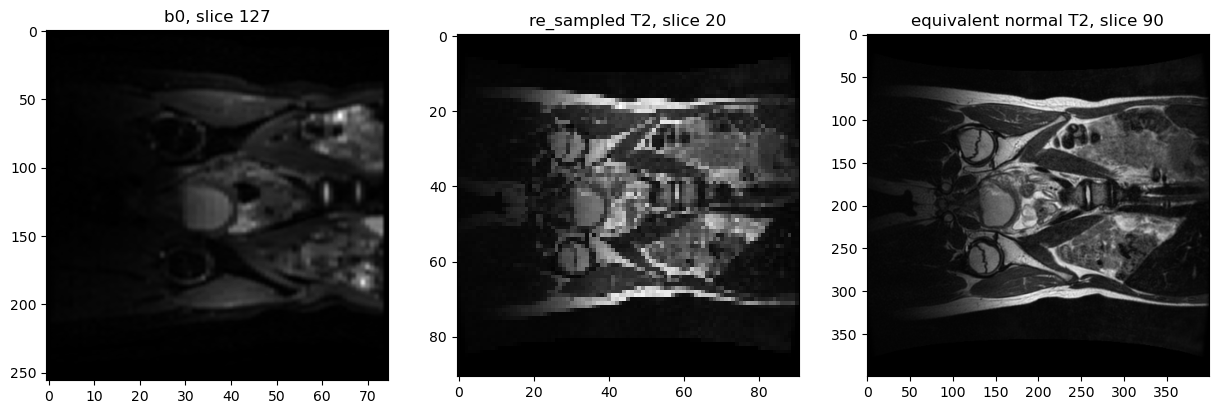

In [57]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,127,:]
plt.imshow(coronal_b0, cmap="gray")
plt.gca().set_aspect(aspect=0.3)
plt.title("b0, slice 127")

plt.subplot(1,3,2)
coronal_resampled_T2 = resampled_T2[:,20,:]
plt.imshow(coronal_resampled_T2, cmap="gray")
plt.title("re_sampled T2, slice 20")

plt.subplot(1,3,3)
coronal_T2 = minor_T2[:,90,:]
plt.imshow(coronal_T2, cmap="gray")
plt.title("equivalent normal T2, slice 90")

plt.show()

### Region of interest (automated with mask)

In [16]:
minor_T2_cut, minor_T2_mask_cut = cut_T2_coro(resampled_T2, resampled_T2_mask)
print(resampled_T2.shape)
print(minor_T2_cut.shape)
#plt.imshow(minor_T2_cut[:,20,:], cmap='gray')

(91, 41, 91)
(91, 41, 46)


In [22]:
## To automate with the affine matrix, we need to modify that of T2 because we resampled it
print(f'affine of original T2 : \n{affine_T2}')
M = affine_T2[0:3,0:3]
T = affine_T2[0:3,3]

## it's like doing a transformation then rescaling
## so we just have to multiply by the scaling factor
zooming_matrix = (1./scale) * np.identity(3) 
M = np.dot(M,zooming_matrix)

affine_T2_resampled = np.zeros_like(affine_T2)
affine_T2_resampled[0:3,0:3] = M
affine_T2_resampled[0:3,3] = T
affine_T2_resampled[3,3] = 1
print(f'affine of resampled T2 : \n{affine_T2_resampled}')

affine of original T2 : 
[[   0.88          0.           -0.         -175.97200012]
 [   0.            0.85000002   -0.          -91.72620392]
 [   0.            0.            0.88       -225.76399231]
 [   0.            0.            0.            1.        ]]
affine of resampled T2 : 
[[   3.84999998    0.            0.         -175.97200012]
 [   0.            3.7187501     0.          -91.72620392]
 [   0.            0.            3.84999998 -225.76399231]
 [   0.            0.            0.            1.        ]]


In [60]:
## transforming the voxel coordinates (T2) to RAS coordinates via affine matrix to have z_min and z_max (to cut coronal slices)

z_min_resampled_T2, z_max_resampled_T2 = cut_T2_coro(resampled_T2, resampled_T2_mask, coordinates=True)
print(z_min_resampled_T2,z_max_resampled_T2) ## result coherent with previous cut (decomment imshow of "region of interest")

(_,_,z_min_RAS) = np.dot(M,(0, 0, z_min_resampled_T2)) + T
(_, _, z_max_RAS) = np.dot(M, (0, 0, z_max_resampled_T2)) + T

print(z_min_RAS,z_max_RAS) ## coherent result

21 67
-144.91399274766445 32.18600629270077


In [24]:
## transforming founded z_min and z_max to RAS coordinates to voxel coordinates (b0) to cut coronal slices

inverse_affine_b0 = np.linalg.inv(affine_b0)
(_,_,z_min_b0,_) = np.dot(inverse_affine_b0, [0,0,z_min_RAS,1])
(_,_,z_max_b0,_) = np.dot(inverse_affine_b0, [0,0,z_max_RAS,1])
print(z_min_b0, z_max_b0)

19.20938709675358 69.80935988004676


There result are quite coherent but there is a problem. Both images now have the same voxel size. After the cut, they should also have the same number of axial slices. But we have $67 - 21 = 46$ slices for T2 and $70 - 19 = 51$ slices for b0. This comes from the fact that using the affine matrix (and modifying them by inverse or matrix product) affects slightly the numbers each time. Therefore, we need to find a way to fix that problem and rectifying the final z_min_b0 and z_max_b0 numbers (to be integers and with a difference of 46). 

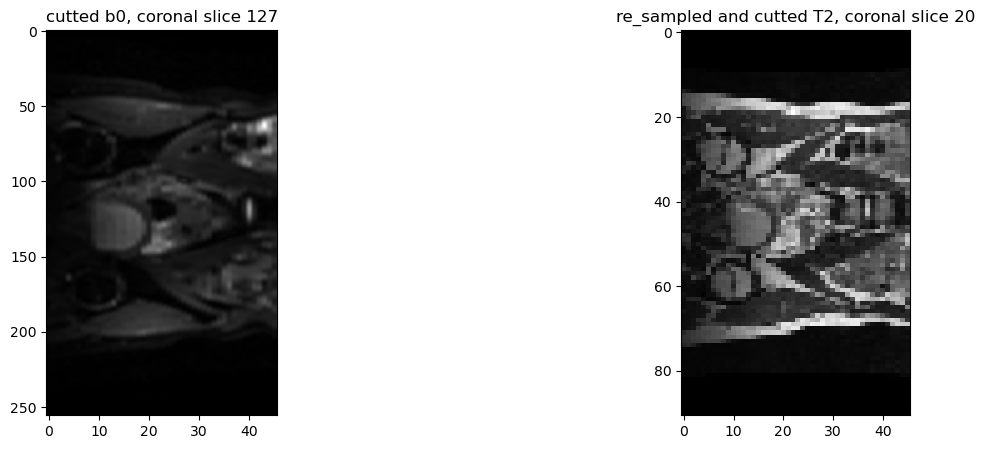

In [53]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
coronal_b0_cut = minor_b0[:,127,21:67]
plt.imshow(coronal_b0_cut, cmap='gray')
plt.gca().set_aspect(aspect=0.3)

plt.title("cutted b0, coronal slice 127")

plt.subplot(1,2,2)
coronal_resampled_T2_cut = resampled_T2[:,20,z_min_resampled_T2:z_max_resampled_T2]
plt.imshow(coronal_resampled_T2_cut, cmap="gray")
plt.gca().set_aspect(aspect=0.85)
plt.gca().xaxis.set_ticks([0, 10, 20, 30, 40])
plt.title("re_sampled and cutted T2, coronal slice 20")

plt.show()

In [54]:
print(f'cutted b0 shape : {minor_b0[:,:,20:69].shape}')
print(f'cutted and re_sampled T2 shape : {resampled_T2[:,:,21:67].shape}')

cutted b0 shape : (256, 256, 49)
cutted and re_sampled T2 shape : (91, 41, 46)


### Region of interest (automated without mask)

In [55]:
## RAS z_min and z_max between resampled T2 and b0

z_min_T2_resampled = 0
z_max_T2_resampled = resampled_T2.shape[2]

z_min_b0 = 0
z_max_b0 = minor_b0.shape[2]

# we transform z_min and z_max from voxel coordinates to RAS coordinates (for T2 and b0)
(_,_,z_min_RAS_T2_resampled) = np.dot(M, (0,0,z_min_T2_resampled)) + T
(_,_,z_max_RAS_T2_resampled) = np.dot(M, (0,0,z_max_T2_resampled)) + T

(_,_,z_min_RAS_b0,_) = np.dot(affine_b0, (0,0,z_min_b0,1))
(_,_,z_max_RAS_b0,_) = np.dot(affine_b0, (0,0,z_max_b0,1))

# we determine which one of them (between T2 and b0) is minimum / maximum
if z_min_RAS_T2_resampled < z_min_RAS_b0 : 
    z_min_RAS = z_min_RAS_T2_resampled
else :
    z_min_RAS = z_min_RAS_b0

if z_max_RAS_T2_resampled > z_max_RAS_b0 :
    z_max_RAS = z_max_RAS_T2_resampled
else :
    z_max_RAS = z_max_RAS_b0

In [56]:
## we get the right min/max voxel coordinates back from T2 and b0
inverse_affine_b0 = np.linalg.inv(affine_b0)
inverse_affine_resampled_T2 = np.linalg.inv(affine_T2_resampled)

(_,_,z_min_b0,_) = np.dot(inverse_affine_b0, [0,0,z_min_RAS,1])
(_,_,z_max_b0,_) = np.dot(inverse_affine_b0, [0,0,z_max_RAS,1])

(_,_,z_min_T2_resampled,_) = np.dot(inverse_affine_resampled_T2, [0,0,z_min_RAS,1])
(_,_,z_max_T2_resampled,_) = np.dot(inverse_affine_resampled_T2, [0,0,z_max_RAS,1])

print(z_min_b0, z_max_b0)
print(z_min_T2_resampled,z_max_T2_resampled)

-3.8906004782280874 96.20934568002579
0.0 91.0


Same problem than with mask method...

### 2D-2D registration

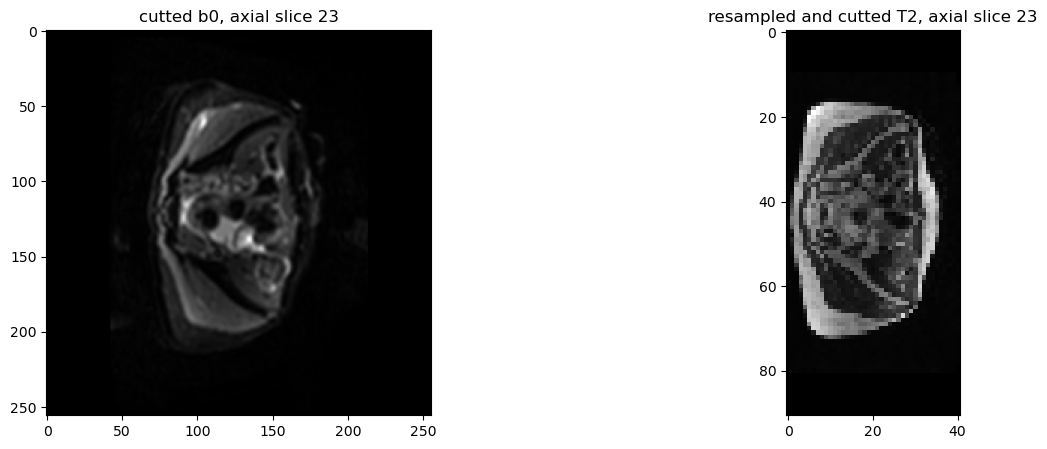

In [62]:
## We are going to try a first 2D-2D registration with the same axial slice of the previous cutted coronal images
## Here are the first two images we'll try to register

minor_b0_cut = minor_b0[:,:,21:67]
minor_resampled_T2_cut = resampled_T2[:,:,21:67]

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
axial_b0_cut_23 = minor_b0_cut[:,:,23]
plt.imshow(axial_b0_cut_23, cmap='gray')
plt.title("cutted b0, axial slice 23")

plt.subplot(1,2,2)
axial_resampled_T2_cut_23 = minor_resampled_T2_cut[:,:,23]
plt.imshow(axial_resampled_T2_cut_23, cmap="gray")
plt.title("resampled and cutted T2, axial slice 23")

plt.show()

Mutual Information I for images A and B : I(A,B) = H(A) + H(B) - H(A,B) where H is Shannon entropy.
Shannon entropy --> scipy.stats.entropy(pk) where pk is the probability distribution.

In [81]:
dico_b0 = dict()
dico_T2 = dict()

N_b0 = axial_b0_cut_23.shape[0] * axial_b0_cut_23.shape[1]
N_T2 = axial_resampled_T2_cut_23.shape[0] * axial_resampled_T2_cut_23.shape[1]

for val in np.unique(axial_b0_cut_23) :
    dico_b0[val] = np.sum(np.where(axial_b0_cut_23==val,1,0)) / N_b0
    
for val in np.unique(axial_resampled_T2_cut_23) :
    dico_T2[val] = np.sum(np.where(axial_resampled_T2_cut_23==val,1,0)) / N_T2

P_b0 = list(dico_b0.values())
P_T2 = list(dico_T2.values())

print(np.sum(P_b0))
print(np.sum(P_T2)) ## < 1 maybe because of rounded values

1.0
0.9999999999999999


In [83]:
H_b0_0 = scipy.stats.entropy(P_b0, base=2)
H_T2_0 = scipy.stats.entropy(P_T2, base=2)

print(H_b0_0)
print(H_T2_0)

8.322635073427278
9.606375108534488


In [ ]:
## on n'a peut-être pas besoin de normaliser

In [68]:
print(np.unique(axial_b0_cut_23))
print(np.unique(axial_resampled_T2_cut_23))

## we need to normalize these values between 0 and 255
axial_b0_cut_23_norm = ((axial_b0_cut_23-np.min(axial_b0_cut_23)) / (np.max(axial_b0_cut_23)-np.min(axial_b0_cut_23))) * 255
axial_resampled_T2_cut_23_norm = ((axial_resampled_T2_cut_23-np.min(axial_resampled_T2_cut_23)) / (np.max(axial_resampled_T2_cut_23)-np.min(axial_resampled_T2_cut_23))) * 255
print(np.unique(axial_b0_cut_23_norm))
print(np.unique(axial_resampled_T2_cut_23_norm))

[ 1080.  1082.  1083. ... 21186. 21302. 21634.]
[   0.           44.08136688   84.65194697 ... 8039.50107151 8047.25152734
 8162.91963281]
[0.00000000e+00 2.48126885e-02 3.72190328e-02 ... 2.49441958e+02
 2.50881094e+02 2.55000000e+02]
[  0.           1.37705001   2.64442717 ... 251.14454943 251.38666455
 255.        ]


In [72]:
P_b0 = np.zeros((256))
P_T2 = np.zeros((256))

P_b0[0] = np.sum(np.where(axial_b0_cut_23_norm==0, 1, 0))
P_T2[0] = np.sum(np.where(axial_resampled_T2_cut_23_norm==0, 1, 0))

for i in range(255) :
    P_b0[i] = np.sum(np.where( (axial_b0_cut_23_norm<=i)&(axial_b0_cut_23_norm>i-1), 1, 0 ))
    P_T2[i] = np.sum(np.where( (axial_resampled_T2_cut_23_norm<=i)&(axial_resampled_T2_cut_23_norm>i-1), 1, 0 ))
